# Part I : Probability

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape

(294478, 5)

In [4]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [5]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [6]:
# The proportion of users converted

df['converted'].value_counts()[1]/(df['converted'].value_counts()[0]
                                   +df['converted'].value_counts()[1])

0.11965919355605512

In [7]:
# The number of times the 'new_page' and 'treatment' didn't match

df.query("group == 'treatment' and landing_page != 'new_page'").count()[0]+\
df.query("group != 'treatment' and landing_page == 'new_page'").count()[0]

3893

In [8]:
df.drop(df.query("group == 'treatment' and landing_page != 'new_page'").index, inplace=True)
df.drop(df.query("group != 'treatment' and landing_page == 'new_page'").index, inplace=True)

df2 = df
df2.shape

(290585, 5)

In [15]:
# check whether all the unwanted records were removed

df2[((df2['group'] == 'treatment')  == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [16]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

In [18]:
# checking duplicates & removing if presents

duplicate = df2[df2['user_id'].duplicated()]
duplicate

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [19]:
df2.drop(duplicate.index, inplace=True)

In [20]:
df2.nunique()

user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
dtype: int64

In [21]:
# probability of converted users

df2[df2['converted'] == 1].count()[4] / df2['converted'].count()

0.11959708724499628

In [23]:
# probability of converted in control group

control = df2.query("group == 'control' and converted == 1").count()[4]/ df2[df2['group'] == 'control'].count()[4]
control

0.1203863045004612

In [24]:
# probability of converted in treatment group

treatment = df2.query("group == 'treatment' and converted == 1").count()[4]/df2[df2['group'] == 'treatment'].count()[4]
treatment

0.11880806551510564

In [25]:
# probability of receiving the new_page

df2.query("landing_page == 'new_page'").count()[3]/df2['landing_page'].count()

0.5000619442226688

### I believe this experimemt design is robust and persuasive with following reasons.

* 1.From above results, there are at least 50% of users willing to land new pages.
* 2.Although only around 11.96% of users convert to new version, the result is still acceptable for me.
* 3.In addition, the probability of an individual received the new page in either "control" or "treatment" groups are around 12% which means not only the size of both groups are similar but the conversion rates are close.


# Part II - A/B Test

In [29]:
# P_new under the null

p_new = df2.query("converted == 1").count()[4]/ df2["converted"].count()
p_new

0.11959708724499628

In [30]:
# P_old under the null

p_old = df2.query("converted == 1").count()[4]/ df2["converted"].count()
p_old

0.11959708724499628

In [31]:
n_new = df2.query('group == "treatment"').count()[0]
n_new

145310

In [32]:
n_old = df2.query('group == "control"').count()[0]
n_old

145274

In [33]:
p_dif = p_new - p_old
p_dif

0.0

In [34]:
# Store 1, 0 in new_page_converted 

new_page_converted = np.random.choice([0,1], n_new, p=(p_new, 1-p_new))
new_page_converted

array([1, 1, 1, ..., 1, 1, 0])

In [35]:
# Store 1, 0 in old_page_converted 

old_page_converted = np.random.choice([0,1], n_old, p=(p_old, 1-p_old))
old_page_converted

array([1, 1, 1, ..., 0, 1, 1])

In [36]:
new_page_converted.mean() - old_page_converted.mean()


0.0015232576057286895

In [37]:
p_diffs = []
size = df2.shape[0]
for i in range(10000):
    sample = df2.sample(size, replace = True)
    new_page_converted = np.random.choice([0,1], n_new, p=(p_new, 1-p_new))
    old_page_converted = np.random.choice([0,1], n_old, p=(p_old, 1-p_old))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

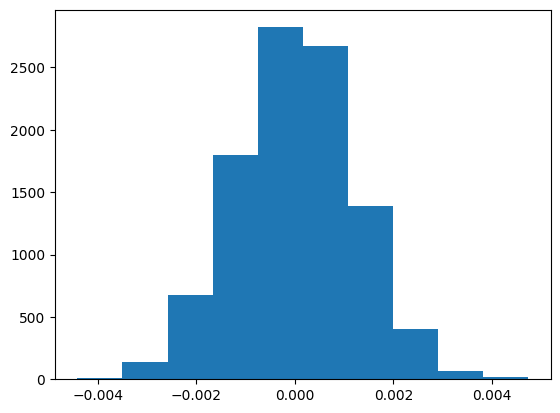

In [38]:
p_diffs = np.array(p_diffs)

plt.hist(p_diffs);

In [39]:
# The differences of actual treatment group and actual control group

obs_diffs = control - treatment
obs_diffs

0.0015782389853555567

In [40]:
# create distribution under the null hypothesis

null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

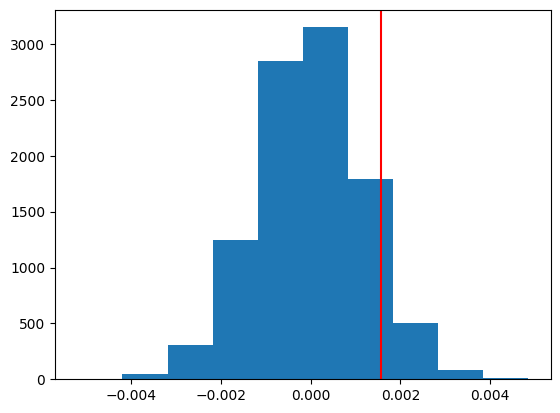

In [41]:
# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(obs_diffs, c = 'red');

In [42]:
# compute p value

(null_vals > obs_diffs).mean()

0.091

* The p-value is 9.6%, higher than Type I error which is 5%; therefore, we should fail to reject the null (H0). Besides, we   can tell that actual p-value of control group is higher than than the treatment group during the calculation.

* In other words, the old verison has higher p-value than the new one, so we keep the old version and do not change to the   new version. Also, there is no difference between the new and old pages.

In [43]:
# Apply A/B testing with statistics package

import statsmodels.api as sm

convert_old = old_page_converted.mean()
convert_new = new_page_converted.mean()

n_old = n_old
n_new = n_new

In [44]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')
z_score, p_value

(-0.0014542398182297675, 0.5005801575448476)

In [45]:
from scipy.stats import norm

# Tell how significant the z-score is
norm.cdf(z_score)

0.49941984245515236

In [46]:
# Tell what the critical value at 95% confidence is

norm.ppf(1-(0.05/2))

1.959963984540054

* The z-score does not exceed the critical value which is around 1.96; therefore, we fail to reject the null (H0).
Also, the p-value is around 50% which is not significant.

* The results are all the same with the findings in parts j. and k. In other words, there is no difference between the new and old pages and we keep the old version and do not change to the new version.

# Part III - A regression approach


* I utilize Logisitc Regression in this case because the response variables are Categorical Variables.

In [47]:
# Logistic Regression approach

df2['intercept'] = 1

df2 = df2.join(pd.get_dummies(df2['landing_page']))
df2['ab_page'] = pd.get_dummies(df2['group']) ['treatment']

In [48]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


In [49]:
logit = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

In [50]:
# Summary: Logistic Regression model  

results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 04 Aug 2023   Pseudo R-squ.:               8.077e-06
Time:                        22:35:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

* The p-value associated with 'ab_page' is 0.19. Obviously, it is different from the value in Part II. The reason is because here we want to know 'ab_page' this attribute is significant or not and it is not significant in this case.
* The null hypothesis is that there is no difference between the treatment and control group. The alternative is that there is difference between the treatment and control group.
* The result will be stronger and more convincing with new variables added into the regression model such as 'timestamp'. Moreover, the result will be stronger and more convincing with new variables added such as 'timestamp'. More specifically, I can classify this factor into 'morning', 'afternoon' and 'evening'. Also I can classify them as 'weekday' and 'weekend' for better performance.
* On the other hand, it will make regression model more complex and I need to check it to see if variables are dependable with each others. If yes, I need to add higher order term to get the better prediction results. Otherwise, the results should be trustworthy.

In [51]:
# Modeling with countries data

countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [52]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [53]:
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [54]:
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new = df_new.drop(['CA'], axis =1)

In [55]:
# Summary: Logistic Regression model

df_new['intercept'] = 1

logit2 = sm.Logit(df_new['converted'], df_new[['intercept','new_page','UK','US']])
result = logit2.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 04 Aug 2023   Pseudo R-squ.:               2.323e-05
Time:                        22:35:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [63]:
1/np.exp(-0.0149),np.exp(0.0506),np.exp(0.0408)


(1.0150115583846535, 1.0519020483004984, 1.0416437559600236)

* From above, we can tell that when 'new_page' decreases one unit, the converted rate will increase 1.5%.
* When 'UK' increases one unit, the converted rate will increase 5.2%.
* When 'US' increases on unit, the converted rate will increase 4.2%.

In [57]:
# Test with more factors

df_new['UK_new_page'] = df_new['new_page']* df_new['UK']
df_new['US_new_page'] = df_new['new_page']* df_new['US']

In [58]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,UK,US,UK_new_page,US_new_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,1,0,1,0


In [59]:
# Summary: Logistic Regression model

logit3 = sm.Logit(df_new['converted'], df_new[['intercept','new_page','UK_new_page','US_new_page','UK','US']])
result = logit3.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 04 Aug 2023   Pseudo R-squ.:               3.482e-05
Time:                        22:35:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0040      0.036    -55.008      0.000      -2.075      -1.933
new_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK_new_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_new_page     0.0469      0.054      0.872      0.383      -0.059       0.152
UK              0.0118      0.040      0.296      0.767      -0.066       0.090
US              0.0175      0.038      0.465      0.642      -0.056       0.091
===============================================================================
"""

In [60]:
1/np.exp(-0.0674),np.exp(0.0783),np.exp(0.0469),np.exp(0.0118),np.exp(0.0175)

(1.0697232819209153,
 1.0814470441230692,
 1.048017202119183,
 1.011869894648401,
 1.0176540221507617)

* From above, we can tell that except the p-value of 'intercept' is less than TypeI error = 5%, other variables are exceed TypeI error = 5% which means they are not significant. In addition, their z-scores are not large enough which means they are not significant as well.
* However, we still can tell that when 'new_page' decreases one unit, the converted will increase 7%.
* When 'UK_new_page' increases one unit, the converted will increase 8.1%.
* When 'US_new_page' increases one unit, the converted will increase 4.8%.
* When 'UK' increases one unit, the converted will increase 1.2%.
* When 'US' increases one unit, the converted will increase 1.8%.